In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 1000 files belonging to 2 classes.


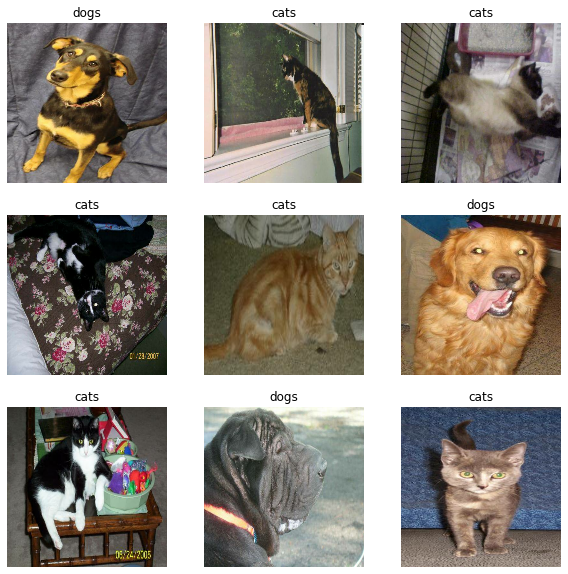

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


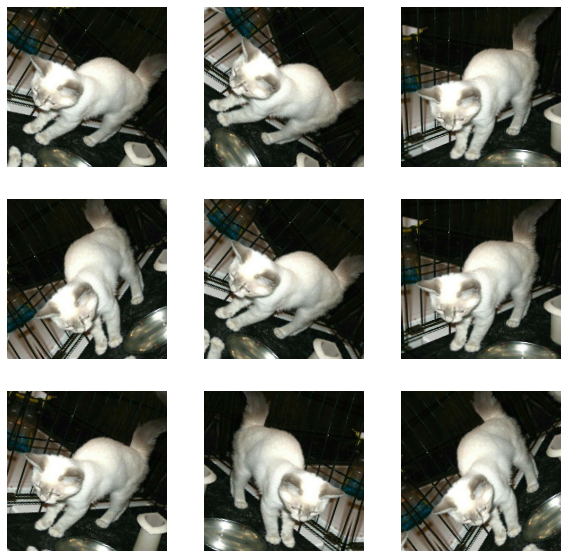

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [18]:
base_model.trainable = False


In [19]:
# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [22]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
len(model.trainable_variables)


2

In [26]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


26/26 [==============================] - 3s 125ms/step - loss: 0.6111 - accuracy: 0.6745


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.61
initial accuracy: 0.67


In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
63/63 [==============================] - 15s 202ms/step - loss: 0.5974 - accuracy: 0.6730 - val_loss: 0.4406 - val_accuracy: 0.7611
Epoch 2/10
63/63 [==============================] - 13s 205ms/step - loss: 0.4599 - accuracy: 0.7600 - val_loss: 0.3239 - val_accuracy: 0.8465
Epoch 3/10
63/63 [==============================] - 13s 207ms/step - loss: 0.3863 - accuracy: 0.8115 - val_loss: 0.2638 - val_accuracy: 0.8800
Epoch 4/10
63/63 [==============================] - 13s 213ms/step - loss: 0.3358 - accuracy: 0.8475 - val_loss: 0.2139 - val_accuracy: 0.9121
Epoch 5/10
63/63 [==============================] - 14s 215ms/step - loss: 0.2969 - accuracy: 0.8655 - val_loss: 0.1810 - val_accuracy: 0.9270
Epoch 6/10
63/63 [==============================] - 14s 217ms/step - loss: 0.2762 - accuracy: 0.8730 - val_loss: 0.1649 - val_accuracy: 0.9356
Epoch 7/10
63/63 [==============================] - 14s 218ms/step - loss: 0.2414 - accuracy: 0.9025 - val_loss: 0.1393 - val_accuracy: 0.9542

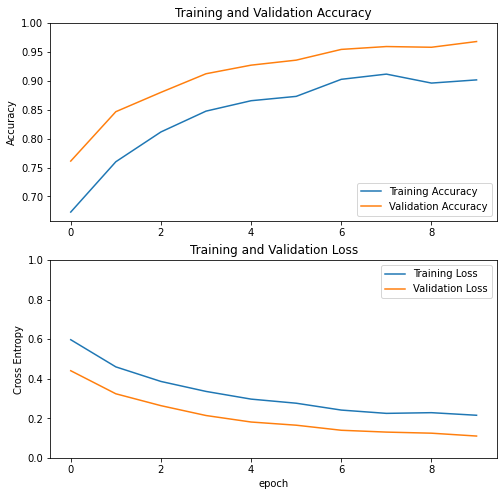

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [26]:
base_model.trainable = True


In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


In [29]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
63/63 [==============================] - 18s 281ms/step - loss: 0.1301 - accuracy: 0.9445 - val_loss: 0.0550 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 18s 292ms/step - loss: 0.1060 - accuracy: 0.9535 - val_loss: 0.0565 - val_accuracy: 0.9715
Epoch 12/20
63/63 [==============================] - 19s 302ms/step - loss: 0.1018 - accuracy: 0.9660 - val_loss: 0.0579 - val_accuracy: 0.9740
Epoch 13/20
63/63 [==============================] - 21s 333ms/step - loss: 0.0913 - accuracy: 0.9620 - val_loss: 0.0395 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 18s 290ms/step - loss: 0.0832 - accuracy: 0.9685 - val_loss: 0.0372 - val_accuracy: 0.9827
Epoch 15/20
63/63 [==============================] - 18s 291ms/step - loss: 0.0722 - accuracy: 0.9705 - val_loss: 0.0487 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 18s 291ms/step - loss: 0.0756 - accuracy: 0.9690 - val_loss: 0.0403 - val_accuracy:

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


In [30]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


6/6 [==============================] - 1s 134ms/step - loss: 0.1207 - accuracy: 0.9688
Test accuracy : 0.96875


In [31]:
model.save('cd_model')


INFO:tensorflow:Assets written to: cd_model/assets


In [35]:
new_model = tf.keras.models.load_model('cd_model')

# Check its architecture
new_model.summary()

new_model.predict(image_batch)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

array([[-4.385806 ],
       [-3.0802913],
       [-2.7103117],
       [-0.7525039],
       [-2.8941956],
       [-4.22229  ],
       [ 3.0993989],
       [-4.3129   ],
       [-2.6950872],
       [-3.0101488],
       [ 2.6299338],
       [-3.4584246],
       [-5.402064 ],
       [ 3.961205 ],
       [ 2.1746082],
       [-3.3796923],
       [-2.976849 ],
       [ 1.7422825],
       [-5.296758 ],
       [-1.5481663],
       [ 2.9558368],
       [ 2.894061 ],
       [-5.068847 ],
       [-2.7156556],
       [-1.7808205],
       [-5.7729173],
       [-3.5959032],
       [ 3.550241 ],
       [ 2.290828 ],
       [-1.8475168],
       [-2.6590586],
       [ 2.5219312]], dtype=float32)

In [3]:
# import pyrealsense2.pyrealsense2 as rs
import numpy as np
import cv2
import tensorflow as tf
import math

import os
import serial
import threading as t
import time



FRAME_WIDTH = 640
FRAME_HEIGHT = 480

OFFSET = 200

DETECT_MIN = (int(FRAME_WIDTH/2)-OFFSET, 0)
DETECT_MAX = (int(FRAME_WIDTH/2)+OFFSET, FRAME_HEIGHT)


LEFT_START_POINT = (int(FRAME_WIDTH/2)-OFFSET, 0) 
LEFT_END_POINT = (int(FRAME_WIDTH/2)-OFFSET, FRAME_HEIGHT)

RIGHT_START_POINT = (int(FRAME_WIDTH/2)+OFFSET, 0) 
RIGHT_END_POINT = (int(FRAME_WIDTH/2)+OFFSET, FRAME_HEIGHT)
  
LINE_COLOR = (0, 0, 255) 

LINE_THICKNESS = 5

OVERRIDE = True
# Configure depth and color streams

# pipeline = rs.pipeline()
# config = rs.config()
# config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)


print("[INFO] Starting streaming...")
# pipeline.start(config)
print("[INFO] Camera ready.")

# download model from: https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API#run-network-in-opencv
print("[INFO] Loading model...")
PATH_TO_CKPT = "./cd_model/saved_model.pb"

# Load the Tensorflow model into memory.
# detection_graph = tf.Graph()
# with detection_graph.as_default(): 
#     od_graph_def = tf.compat.v1.GraphDef()
#     with tf.compat.v1.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
#         serialized_graph = fid.read()
#         od_graph_def.ParseFromString(serialized_graph)
#         tf.compat.v1.import_graph_def(od_graph_def, name='')
#     sess = tf.compat.v1.Session(graph=detection_graph)
model = tf.saved_model.load("./cd_model")

# coordinate distance
def distance(x1, x2, y1, y2):
    # width =math.sqrt( ((xmin-ymin)**2)+((xmax-ymin)**2) )
    # height = math.sqrt( ((xmax-ymin)**2)+((xmax-ymax)**2) )
    # area = int((width * height)/100)
    return math.sqrt( ((x1-x2)**2)+((y1-y2)**2) )


SPEED = 0
DIRECTION= 30

# # input to arduino 
# def writeArduiono():
#     while True:
#         if DIRECTION == 0 or DIRECTION == 90:
#             ACTION = (str(DIRECTION)+"#" +str(SPEED)+ "\n").encode('utf_8')

#             print(ACTION)
#             ser.write(ACTION)
#             line = ser.readline().decode('utf-8').rstrip()	
#             print(line)
#             time.sleep(0.2)
#         else:
#             ACTION = (str(DIRECTION)+"#" +str(SPEED)+ "\n").encode('utf_8')

#             print(ACTION)
#             ser.write(ACTION)
#             line = ser.readline().decode('utf-8').rstrip()	
#             print(line)


# # start motor thread for individual process
# motorThread = t.Thread(target = writeArduiono, daemon=True)
# motorThread.start()
hasStarted = False

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# code source of tensorflow model loading: https://www.geeksforgeeks.org/ml-training-image-classifier-using-tensorflow-object-detection-api/
print("[INFO] Model loaded.")
colors_hash = {}
classes_90 = ["background", "person", "bicycle", "car", "motorcycle",
            "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
            "unknown", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
            "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "unknown", "backpack",
            "umbrella", "unknown", "unknown", "handbag", "tie", "suitcase", "frisbee", "skis",
            "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
            "surfboard", "tennis racket", "bottle", "unknown", "wine glass", "cup", "fork", "knife",
            "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
            "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "unknown", "dining table",
            "unknown", "unknown", "toilet", "unknown", "tv", "laptop", "mouse", "remote", "keyboard",
            "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "unknown",
            "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush", "cone" ] 

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, FRAME_WIDTH)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, FRAME_HEIGHT)
while True:
    # frames = pipeline.wait_for_frames()
    # color_frame = frames.get_color_frame()

    # # Convert images to numpy arrays
    # color_image = np.asanyarray(color_frame.get_data())
    # scaled_size = (color_frame.width, color_frame.height)
    # # expand image dimensions to have shape: [1, None, None, 3]
    # # i.e. a single-column array, where each item in the column has the pixel RGB value
    # image_expanded = np.expand_dims(color_image, axis=0)
    # # Perform the actual detection by running the model with the image as input
    # (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],
    #                                             feed_dict={image_tensor: image_expanded})



    _, frame = cap.read()
    
    # scaled_size = (frame.width, frame.height)
    # expand image dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    image_expanded = np.expand_dims(frame, axis=0)
    # Perform the actual detection by running the model with the image as input
    (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],
                                                feed_dict={image_tensor: image_expanded})
    boxes = np.squeeze(boxes)
    classes = np.squeeze(classes).astype(np.int32)
    scores = np.squeeze(scores)
       
    detected = False
    hasLeft = False
    hasRight = False
    

    right_cone = None
    left_cone = None
    
    for idx in range(int(num)):
        class_ = classes[idx]
        score = scores[idx]
        box = boxes[idx]

        # print(class_,classes_90[class_])

        if class_ not in colors_hash:
            colors_hash[class_] = tuple(np.random.choice(range(256), size=3))
        
	# 47 is cup class
        print(classes_90[class_])
        if score > 0.5:
        # if score > 0.01 and class_ == 47:
            left = int(box[1] * FRAME_WIDTH)
            top = int(box[0] * FRAME_HEIGHT)
            right = int(box[3] * FRAME_WIDTH)
            bottom = int(box[2] * FRAME_HEIGHT)

            avg_x = (left+right)/2
            avg_y = (top+bottom)/2
            width = distance(left, right, top, bottom)
            height = distance(left, right, top, bottom)
			# height = math.sqrt( ((xmax-ymin)**2)+((xmax-ymax)**2) )
            area = int((width * height)/100)
            # print(area)
            if(area > 45 and area < 1000):
                p1 = (left, top)
                p2 = (right, bottom)
		        # draw box
                r, g, b = colors_hash[class_]

                if((avg_x  > LEFT_START_POINT[0] and avg_x < RIGHT_START_POINT[0]) or (avg_y > LEFT_START_POINT[1] and avg_y < RIGHT_START_POINT[1]) ):
                    detected = True
                if(avg_x  < (FRAME_WIDTH/2)):
                    cone = "LEFT"
                else:
                    cone = "RIGHT"
                if(cone == "LEFT"):
                    if(hasLeft):
                        pass
                    else:
                        hasLeft = True
                        left_cone = ((right+right)/2, (top+bottom)/2)

                        cv2.rectangle(frame, p1, p2, (int(r), int(g), int(b)), 2, 1)
                        cv2.putText(frame, classes_90[class_], p1,  cv2.FONT_HERSHEY_SIMPLEX,  
                            1, (255,0,0), 2, cv2.LINE_AA) 

                if(cone == "RIGHT"):
                    if(hasRight):
                        pass
                    else:
                        hasRight = True
                        right_cone = ((right+right)/2, (top+bottom)/2)

                        cv2.rectangle(frame, p1, p2, (int(r), int(g), int(b)), 2, 1)
                        cv2.putText(frame, classes_90[class_], p1,  cv2.FONT_HERSHEY_SIMPLEX,  
                            1, (255,0,0), 2, cv2.LINE_AA) 
            

        CENTER_X = (int(FRAME_WIDTH/2))

        if(detected):
            LINE_COLOR = (0,0,255)
        else:
            LINE_COLOR = (0,255,0)
        
        if left_cone is None:
            left_cone = (0,FRAME_HEIGHT/2)

        if right_cone is None:
            right_cone = (FRAME_WIDTH, FRAME_HEIGHT/2)
        
        #  middle of two objects
        _mid = (left_cone[0]+right_cone[0])/2
        if(OVERRIDE == False):
            if(detected):
                if((_mid < CENTER_X and _mid > LEFT_START_POINT[0])):   
                    
                    DIRECTION = 60
                elif((_mid > CENTER_X and _mid < RIGHT_START_POINT[0])):
                    DIRECTION = 0
            else:
                DIRECTION = 30
            SPEED = 10
        else:
            SPEED = 0
            DIRECTION = 30
    cv2.circle(frame, (int(FRAME_WIDTH/2), int(FRAME_HEIGHT/2)), 20, (255,255,0), 2)
    cv2.line(frame, LEFT_START_POINT, LEFT_END_POINT, LINE_COLOR, LINE_THICKNESS) 
    cv2.line(frame, RIGHT_START_POINT, RIGHT_END_POINT, LINE_COLOR, LINE_THICKNESS) 
    cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
    cv2.putText(frame,f"Overide State: {OVERRIDE}", (10,30),  cv2.FONT_HERSHEY_SIMPLEX,  
		               1, (255,0,0), 2, cv2.LINE_AA) 

    cv2.imshow('RealSense', frame)
    t = cv2.waitKey(1)
    if t == ord('q'):
        break
    
    if t == ord('s'):
        if OVERRIDE == False:
            OVERRIDE = True
            print("Overide ON")
        else:
            OVERRIDE = False
            print("Overdie OFF")
cap.release()
cv2.destroyAllWindows()
print("[INFO] stop streaming ...")
# pipeline.stop()



[INFO] Starting streaming...
[INFO] Camera ready.
[INFO] Loading model...


AttributeError: '_UserObject' object has no attribute 'get_tensor_by_name'